# **PROYECTO PREDICTIVO DE CANCER DE MAMA**


## **Modelos l - Proyecto Sustituto (2025-1)**

Andres Dario Higuita Perez - C.C: 1022099411 - adario.higuita@udea.edu.co

### **Basado en Proyecto de Kaggle:**

**Competición:**
https://www.kaggle.com/competitions/rsna-breast-cancer-detection/code?competitionId=39272&sortBy=voteCount&excludeNonAccessedDatasources=true

**NoteBook:**
https://www.kaggle.com/code/radek1/eda-training-a-fast-ai-model-submission


**Profesor: RAUL RAMOS POLLAN**

**UNIVERSIDAD DE ANTIOQUIA**

*Ejecutar el notebook con googleColab prioritariamente para una correcta conexión a Drive institucional...*


## **Paso a paso de ejecución del proyecto**

1. Se realiza la instalación librerías necesarias para la correcta ejecución del los siguientes pasos.


*Ignorar advertencias de conflicto de dependencias, ya que es un conflicto dificil de resolver en la versiones de colab, mas sin embargo los bloques de codigo se ejecutan sin problema en su mayoria y solo hay un paso que puede fallar pero tiene solución indicada.*

In [ ]:
!pip install -Uqq numpy==1.24.4 fastai==2.7.12 pydicom==2.4.4 pylibjpeg pylibjpeg-libjpeg
!apt-get install -y python3-gdcm

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-gdcm is already the newest version (3.0.10-1build2).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


2. Se realiza ejecución de codigo para la conexión a Drive donde estarán alojados los archivos de train y test, previamente compartidos al profesor Raul y monitor Jonathan. Para ello deben realizar lo siguiente:

**⚠️ ¡¡IMPORTANTE!!**  
   **Siga los siguientes pasos en orden, de arriba hacia abajo, para que la sincronización con Google Drive sea exitosa:**

   a. ✅ **Aceptar acceso compartido**  
      Acepte la invitación para acceder a la carpeta **Modelos_l** compartida por **Andrés Higuita** desde el correo `adario.higuita@udea.edu.co`.

   b. 📂 **Mover la carpeta a “Mi unidad”**  
      Ingrese a su [Google Drive](https://drive.google.com), ubique la carpeta **Modelos_l** en la sección **"Compartido conmigo"**, y arrástrela hacia **"Mi unidad"**.  
      Esto añadirá un acceso directo necesario para gestionarla desde el Notebook en Colab.

   c. ▶️ **Ejecutar el código de conexión**  
      En el Notebook de Colab, ejecute la celda correspondiente para montar Google Drive.

   d. 🔐 **Autorizar acceso a archivos**  
      Cuando se lo solicite, permita que el Notebook acceda a sus archivos de Google Drive.

   e. 🏫 **Usar cuenta institucional**  
      Inicie sesión con su **cuenta institucional** (la misma a la que se compartió la carpeta **Modelos_l**).

   f. ✅ **Aceptar todos los permisos**  
      Acepte **todas las solicitudes de permisos por defecto**. En total, son **8 servicios** que el Notebook necesita para acceder y sincronizar.

   g. ☁️ **Confirmar y sincronizar**  
      Una vez completados los pasos anteriores, el sistema sincronizará automáticamente los archivos compartidos.

   h. 📁 **Ruta de acceso en el entorno Colab**  
      Los archivos estarán disponibles desde la siguiente ruta dentro del entorno del Notebook:  
      `/content/drive/MyDrive/Modelos_l/`




In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


3. Una vez aceptado el acceso a la carpeta compartida en Google Drive, se procede a extraer los archivos necesarios para el entrenamiento y prueba del modelo desde la carpeta base **Modelos_l**. Para ello, debe ejecutarse el bloque de código correspondiente en el notebook.

   Este paso realizará lo siguiente:

   - 📁 Se crea automáticamente una carpeta llamada **`rsna_project`** dentro del directorio **`/content/`** del entorno de Colab.
   - 📦 Dentro de esta carpeta se extraen o ubican los archivos y carpetas compartidas desde Drive, específicamente:
     - `train.csv` → Archivo con datos de entrenamiento.
     - `test.csv` → Archivo con datos de prueba.
     - `train_images/` → Carpeta que contiene las imágenes utilizadas para entrenar el modelo.
     - `test_images/` → Carpeta que contiene las imágenes que serán utilizadas para realizar predicciones.

   ✅ Asegúrese de que los archivos estén correctamente ubicados en la carpeta **Modelos_l** dentro de su Google Drive antes de ejecutar este paso.


In [ ]:
import os
from pathlib import Path

# Ruta en Google Drive
drive_path = Path("/content/drive/MyDrive/Modelos_l/rsna_project")
assert drive_path.exists(), "❌ La carpeta 'rsna_project' no existe en tu Google Drive."

# Crear carpeta local
data_path = Path("rsna_data")
data_path.mkdir(exist_ok=True)

# Copiar archivos necesarios
!cp "{drive_path}/train.csv" rsna_data/
!cp "{drive_path}/test.csv" rsna_data/
!cp "{drive_path}/train_images.zip" .
!cp "{drive_path}/test_images.zip" .

# Descomprimir imágenes
!unzip -q train_images.zip -d rsna_data
!unzip -q test_images.zip -d rsna_data


4. Se realiza importación de librerias.

**⚠️ ¡¡IMPORTANTE!!**  
   Si aparece un error al importar `fastai.vision.all`, debe **reiniciar el entorno de ejecución** siguiendo estos pasos:

   a. 🧭 Dirígete a la barra de opciones superior del notebook de Colab.  
   b. 🔄 Haz clic en **"Entorno de ejecución"**.  
   c. 📌 En el menú desplegable, selecciona **"Reiniciar la sesión"**.  
   d. ⏳ Espera unos segundos a que se reinicie el entorno por completo.  
   e. ✅ Una vez reiniciado, puedes continuar ejecutando el resto del código **sin inconvenientes**.

   ---

   💡 *Reiniciar el entorno suele resolver errores relacionados con incompatibilidades temporales de librerías.*


In [ ]:
from fastai.vision.all import *
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
from pathlib import Path
import os

5. Se define ruta de trabajo y cargar train.csv

In [ ]:
# Crea un objeto de tipo Path apuntando a la carpeta donde están los datos del proyecto (por ejemplo, imágenes y archivos CSV)
path = Path('rsna_data')

# Lee el archivo 'train.csv' ubicado dentro del directorio 'rsna_data' y lo carga en un DataFrame de pandas
df = pd.read_csv(path/'train.csv')

# Muestra las primeras 5 filas del DataFrame para visualizar un resumen inicial de los datos
df.head()


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


6. Se acondiciona función para leer .dcm como imagen

In [ ]:
# Función para convertir una imagen DICOM (.dcm) en una imagen tipo PIL que pueda usarse con FastAI
def dcm_to_image(dcm_path):
    # Lee el archivo DICOM desde la ruta especificada
    dcm = pydicom.dcmread(dcm_path)

    # Extrae los datos de imagen del archivo DICOM y los convierte a tipo float32 para procesamiento
    img = dcm.pixel_array.astype(np.float32)

    # Normaliza los valores de píxel al rango [0, 1] para estandarizar la escala de grises
    img = (img - np.min(img)) / (np.max(img) - np.min(img))

    # Convierte la imagen normalizada a tipo uint8 (valores entre 0 y 255) y la transforma en una imagen PIL
    return PILImage.create((img * 255).astype(np.uint8))


7. Se acondiciona función para obtener el path de cada imagen .dcm

In [ ]:
# Función para encontrar la ruta completa de un archivo DICOM (.dcm) dado su ID de imagen
def get_dcm_path(image_id, base_path, folder_name):
    # Construye la ruta base donde se buscarán los archivos DICOM
    search_path = base_path / folder_name

    # Busca recursivamente archivos que coincidan exactamente con el nombre 'image_id.dcm'
    matches = list(search_path.rglob(f"{image_id}.dcm"))

    # Si se encontró al menos un archivo que coincida, retorna su ruta
    if matches:
        return matches[0]
    else:
        # Si no se encontró ningún archivo, muestra una advertencia y retorna None
        print(f"⚠️ Imagen {image_id}.dcm no encontrada en {folder_name}")
        return None


8. Se realiza un filtrado de las imágenes que realmente existen dentro del train

In [ ]:
# Función que verifica si existe la imagen DICOM con el ID dado en la carpeta especificada
def image_exists(image_id, folder_name):
    # Llama a la función get_dcm_path para intentar obtener la ruta del archivo
    # Retorna True si la imagen existe (es decir, la ruta no es None), False en caso contrario
    return get_dcm_path(image_id, path, folder_name) is not None

# Filtra el DataFrame original para conservar solo las filas cuya imagen realmente existe
df_filtered = df[df['image_id'].apply(lambda x: image_exists(x, 'train_images'))].reset_index(drop=True)

# Muestra cuántas imágenes válidas fueron encontradas y conservadas en el nuevo DataFrame
print(f"🔢 Total de imágenes encontradas: {len(df_filtered)}")


Se truncaron las últimas líneas 5000 del resultado de transmisión.
⚠️ Imagen 159110654.dcm no encontrada en train_images
⚠️ Imagen 887426674.dcm no encontrada en train_images
⚠️ Imagen 1136150274.dcm no encontrada en train_images
⚠️ Imagen 335778602.dcm no encontrada en train_images
⚠️ Imagen 1657034655.dcm no encontrada en train_images
⚠️ Imagen 625719002.dcm no encontrada en train_images
⚠️ Imagen 1186739164.dcm no encontrada en train_images
⚠️ Imagen 939566995.dcm no encontrada en train_images
⚠️ Imagen 1154699412.dcm no encontrada en train_images
⚠️ Imagen 549972940.dcm no encontrada en train_images
⚠️ Imagen 599167493.dcm no encontrada en train_images
⚠️ Imagen 92618283.dcm no encontrada en train_images
⚠️ Imagen 1214214469.dcm no encontrada en train_images
⚠️ Imagen 191294190.dcm no encontrada en train_images
⚠️ Imagen 669536679.dcm no encontrada en train_images
⚠️ Imagen 882454541.dcm no encontrada en train_images
⚠️ Imagen 1068923688.dcm no encontrada en train_images
⚠️ Imagen 

9. Se preparan los datos con DataBlock

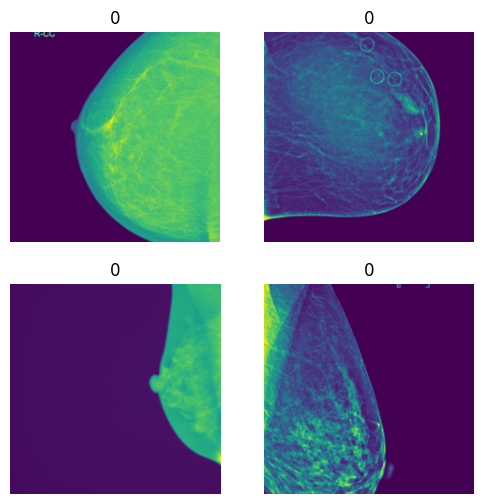

In [ ]:
# Función que recibe una fila del DataFrame y devuelve la imagen convertida
def get_x(row):
    # Obtiene la ruta del archivo .dcm a partir del ID de imagen
    p = get_dcm_path(row['image_id'], path, 'train_images')
    if p is not None:
        # Si se encuentra el archivo, lo convierte a una imagen en formato PIL
        return dcm_to_image(p)
    else:
        # Si no se encuentra el archivo, lanza un error
        raise FileNotFoundError(f"No se encontró la imagen para ID: {row['image_id']}")


# Crea un bloque de datos (DataBlock) de FastAI para preparar el conjunto de entrenamiento/validación
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),             # Define los tipos de entrada (imagen) y salida (categoría)
    get_x=get_x,                                    # Función para obtener la imagen a partir de una fila
    get_y=lambda row: row['cancer'],                # Función para obtener la etiqueta (0 o 1) desde la columna 'cancer'
    splitter=RandomSplitter(valid_pct=0.2, seed=42),# Divide aleatoriamente el dataset en 80% entrenamiento y 20% validación
    item_tfms=Resize(224)                           # Redimensiona todas las imágenes a 224x224 píxeles
)

# Aplica el bloque de datos sobre el DataFrame filtrado y crea los dataloaders
dls = dblock.dataloaders(df_filtered, bs=16)       # Carga los datos en lotes (batch size 16)

# Muestra un lote de 4 imágenes con sus etiquetas para comprobar que se cargaron correctamente
dls.show_batch(max_n=4)


10. Se realiza entrenamiento del modelo

In [ ]:
# Crea un modelo de visión por computadora usando un modelo preentrenado (resnet18)
learn = vision_learner(
    dls,             # Los dataloaders que contienen las imágenes y etiquetas
    resnet18,        # El modelo base preentrenado que se usará como arquitectura (en este caso, ResNet18)
    metrics=accuracy # La métrica que se usará para evaluar el rendimiento del modelo (precisión)
)

# Ajusta (fine-tune) el modelo durante 2 épocas
learn.fine_tune(2)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,1.288414,0.960443,0.611111,01:46


epoch,train_loss,valid_loss,accuracy,time
0,0.953438,1.102875,0.333333,01:43
1,1.115241,0.686032,0.722222,01:41


11. Se hacen predicciones sobre el set de prueba

In [ ]:
# Cargar el dataframe del set de prueba
df_test = pd.read_csv(path/'test.csv')
print(f"📁 Imágenes en el set de prueba: {len(df_test)}")

# Función para hacer predicciones con el modelo entrenado
def predict_test_image(image_id):
    dcm_path = get_dcm_path(image_id, path, 'test_images')
    if dcm_path is not None:
        img = dcm_to_image(dcm_path)
        pred, _, probs = learn.predict(img)
        return probs[1].item() # probabilidad de 'cancer' == 1
    else:
        return 0.0  # o np.nan si prefieres marcar como faltante

# Aplicar la predicción a cada imagen del set de prueba
df_test['cancer'] = df_test['image_id'].apply(predict_test_image)

📁 Imágenes en el set de prueba: 4


12. Se genera archivo submission.csv con los resultados de la predicción realizada.

In [ ]:
# Guardar archivo en formato submission de Kaggle
submission_path = path/'submission.csv'
df_test[['image_id', 'cancer']].to_csv(submission_path, index=False)
print(f"✅ Archivo guardado en: {submission_path}")


✅ Archivo guardado en: rsna_data/submission.csv
